# Homework 4

The goal of this homework is to take part in the [Dog Breed classification](https://www.kaggle.com/c/dog-breed-identification/data) on Kaggle. We are supposed to implement two networks using TensorFlow:

1. Neural network consisting only of dense layers
2. Convolutional network

The goal is mainly to get the optimization to work and to get reasonable results. At the end of the notebook we perform a third step that uses **Keras** and **transfer learning**.

In [24]:
# Import all libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import os.path
import scipy.misc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import skimage.color

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


## Data exploration

As mentioned above, the goal is to classify the images into dog breeds. In order to get a feel for the problem, let us take a look at the number of examples and the distribution of the target variables:

We have 10222 training examples.


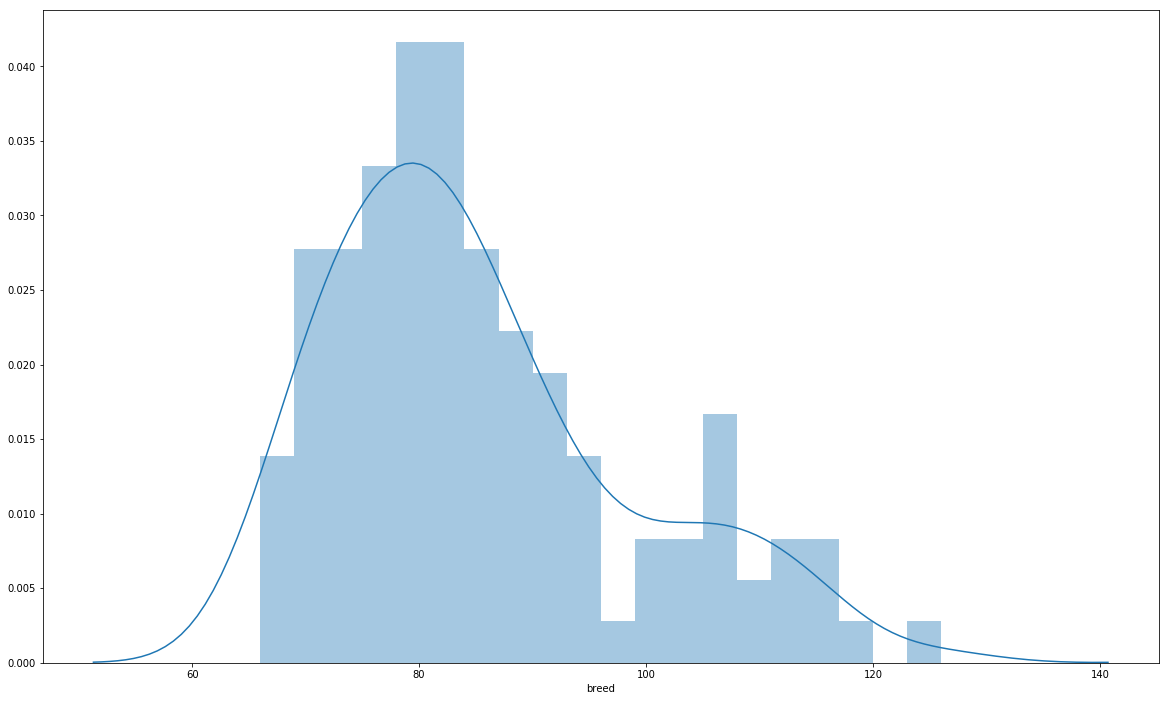

In [25]:
labels = pd.read_csv("data/labels.csv")
print("We have {} training examples.".format(labels.shape[0]))
sns.distplot(labels['breed'].value_counts(), bins=20)

We see that there is no massive imbalance (roughly 2:1 between the most common and the least common dog breed). What we also see, is that there are actually not too many examples per class and the dataset is not too big (around 10000).

In [26]:
labels.columns

Index(['id', 'breed'], dtype='object')

In [27]:
def read_image(row_number, labels):
    """
    Reads an image from the training labels.
    """
    image_id = labels['id'][row_number]
    image_path = os.path.join("data/", "train", image_id + ".jpg")
    image = scipy.misc.imread(image_path)
    return image

def show_image_and_labels(row_number, labels, ax):
    """
    Shows an image together with its labels.
    """
    label = labels['breed'][row_number]
    textstr = "This is a {}.".format(label)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.imshow(read_image(row_number, labels))
    ax.text(0.05, 0.95, textstr, fontsize=18, verticalalignment='top', bbox=props)
    ax.axis('off')

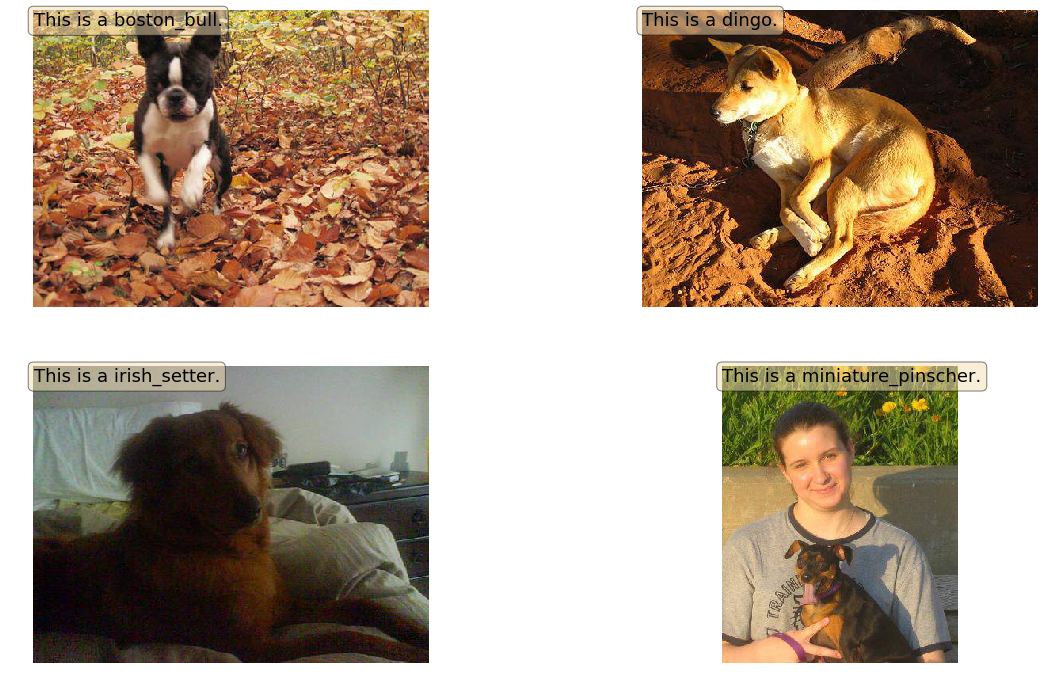

In [28]:
fig, ax = plt.subplots(2, 2)
show_image_and_labels(0, labels, ax[0, 0])
show_image_and_labels(1, labels, ax[0, 1])
show_image_and_labels(1000, labels, ax[1, 0])
show_image_and_labels(2540, labels, ax[1, 1])

It does not look like this is an easy problem. 

Also, the images have various shapes. Thus, in the training data generation we need to make sure that we reshape them all to the same size. Let us next do a splitting of our data into a training test and validation set. We take 90% of the data for training and 10% for cross validation. We take no test set and "test" on the prediction set and submit to Kaggle.

In [29]:
labels_train, labels_cv = train_test_split(labels, train_size=0.9)

/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Neural Network

We start by building a standard dense neural network (i.e. no convolutions) in TensorFlow. The first step is to write a generator function that delivers batches of data to TensorFlow. It returns a number of images and the corresponding labels. The resulting image shape can be adjusted.

In [7]:
def batch_gen(batch_size, labels, encoder, image_shape=(128, 128), normalize=True, to_gray=False):
    """
    Generate function to create batches of training data. The output labels are encoded as integers (to be fed into
    tf.one_hot).
    :param batch_size: batch size
    :param labels: data frame with labels and ids
    :param encoder: encoder to transform the text labels into one-hot-encoded labels. LabelBinarizer from sklearn.
    :param image_shape: shape of output image
    :param normalize: Boolean indicating whether or not to normalize the image
    :param to_gray: boolean indicating whether to convert the image to grayscale
    """
    # Get sample ids
    sample_rows = np.random.randint(low=0, high=labels.shape[0], size=batch_size)
    sample_ids = labels['id'].iloc[sample_rows]
    
    # Get images
    image_paths = [os.path.join("data/", "train", image_id + ".jpg") for image_id in sample_ids]
    images = [scipy.misc.imread(image_path) for image_path in image_paths]
    images_resized = [scipy.misc.imresize(image, image_shape) for image in images]
    images_stacked = np.stack(images_resized)
    if to_gray:
        images_stacked = skimage.color.rgb2gray(images_stacked)
        
    if normalize:
        images_stacked = normalize_image(images_stacked)
    
    # Get labels
    labels_out = labels['breed'].iloc[sample_rows].values
    labels_out = encoder.transform(labels_out)
    
    return images_stacked, labels_out

Next, we write a function for image preprocessing. We normalize an image to have pixels in range $(-1, 1)$. This is done using the formula

$$ x_{norm} = (x - 128) / 256$$

since the range of the original images is $[0, 255]$.

In [8]:
def normalize_image(x):
    """
    Normalizes an image with pixel values in range [0, 255] to have range in [-1, 1].
    :param x: numpy array
    """
    x_normalized = (x - 128.0) / 256.0
    return x_normalized

After these preprocessing steps we can start by writing the logistic regression model. We start with a function that defines the computational graph. It initializes the input $x$ as placeholder, the weights $w$ and bias $b$ as variables that can be optimized and returns both the input tensor, the output tensor and the regularizer.

In [9]:
def logistic_graph(image_shape, num_classes=120):
    """
    Builds the computational graph for a logistic regression model.
    :param image_shape: tuple indicating the image size
    """
    # Input tensor
    input_shape = [item for sublist in ([None], image_shape) for item in sublist]
    x = tf.placeholder(tf.float32, input_shape, name='input')
    
    # Flatten input tensor
    x_flattened = tf.reshape(x, (-1, image_shape[0]*image_shape[1]*image_shape[2]), 
                             name='input_flattened')
    
    # Initialize weights and bias
    w = tf.Variable(tf.truncated_normal(stddev=0.01, 
                                        shape=(x_flattened.get_shape().as_list()[1], num_classes)),
                    name='weights')
    b = tf.Variable(tf.truncated_normal([num_classes], stddev=0.01), name='bias')
    
    # Logits
    logits = tf.matmul(x_flattened, w) + b
    
    # Loss function using L2 Regularization
    regularizer = tf.nn.l2_loss(w)

    return x, logits, regularizer

Next, we write the loss and the optimizer. We define the cross entropy loss function and a regularization term to it. As optimier, we use `Adagrad`.

In [10]:
def logistic_loss(logits, y, regularizer, beta=0, learning_rate=0.01, num_classes=120):
    """
    Computes the loss function. Returns the output tensor, the training operation and loss tensor.
    :param logits: logits as tensor
    :param labels: numpy array of labels as integers
    :param learning_rate: learning rate
    :param num_classes: number of target classes
    """
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    loss = cross_entropy + beta * regularizer
    
    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return train_op, cross_entropy, accuracy

Now, a function that does the training and prints the training and cross validation loss.

In [11]:
def train_logistic(sess, epochs, batch_size, get_batches_fn, get_batches_fn_cv, train_op, cross_entropy, accuracy, input_image,
                   correct_label, labels_train, labels_cv, image_shape, encoder, learning_rate, 
                   num_batches_per_epoch, to_gray=False):
    """
    Train the neural network.
    :param sess: tensorflow session
    :param epochs: number of epochs
    :param batch_size: number of images and labels to bed at a time
    :param get_batches_fn: training generator
    :param get_batches_fn: cv generator
    :param train_op: training operation
    :param cross_entropy: loss tensor
    :parma accuracy: accuracy tensor
    :param input_image: input image tensor
    :param correct_label: correct label tensor
    :param labels_train: dataframe with training labels
    :param labels_cv: dataframe with cross validation labels
    :param image_shape: image shape to resize
    :param encoder: encoder to transform character to integer
    :param learning_rate: learning rate
    :param num_batches_per_epochs: number of batches to use before calling it an epoch
    :param to_gray: whether or not to use gray scale
    """
    print("Start the training")
    print()
    for i in range(epochs):
        for k in range(num_batches_per_epoch):
            x_batch, y_batch = get_batches_fn(batch_size, labels_train, encoder, image_shape, normalize=True, to_gray=to_gray)
        
            _, loss, train_acc = sess.run([train_op, cross_entropy, accuracy], 
                               feed_dict={input_image: x_batch, correct_label: y_batch})
            
            print(k, loss)
            if (k == (num_batches_per_epoch-1)):
                x_batch, y_batch = get_batches_fn_cv(labels_cv.shape[0], labels_cv, encoder, image_shape, to_gray=to_gray)
                cv_loss, cv_acc = sess.run([cross_entropy, accuracy],
                                           feed_dict={input_image: x_batch, correct_label: y_batch})
                print("In epoch number {} the training loss is {:.3f} and the cv loss is {:.3f}.".format(i+1, loss, cv_loss))
                print("The training accuracy is {:.3f} and the cv accuracy is {:.3f}.".format(train_acc, cv_acc))
                print(" ")

Finally, we run the logistic regression: this means that we set the $\beta$ parameter to zero.

In [12]:
def run_session(img_shape, batch_size, learning_rate, beta, epochs):
    
    with tf.Session() as sess:
        
        img_shape_full = [item for sublist in ([img_shape, [3]]) for item in sublist]

        num_classes = 120
        encoder = LabelBinarizer()
        encoder.fit(labels['breed'])



        num_batches_per_epoch = labels_train.shape[0] // batch_size

        x_tensor, logits, regularizer = logistic_graph(img_shape_full, num_classes=num_classes)

        correct_labels_tensor = tf.placeholder(shape=(None, num_classes), dtype=tf.int64)
        optimizer, loss, accuracy = logistic_loss(logits, correct_labels_tensor, regularizer, beta, num_classes=num_classes)

        sess.run(tf.global_variables_initializer())

        train_logistic(sess, epochs, batch_size, batch_gen, batch_gen, optimizer, loss, accuracy, x_tensor,
                       correct_labels_tensor, labels_train, labels_cv, img_shape, encoder, learning_rate, 
                       num_batches_per_epoch=num_batches_per_epoch)



In [13]:
# Params
img_shape = (32, 32)
batch_size = 100
learning_rate = 0.03
beta = 0
epochs = 10

run_session(img_shape, batch_size, learning_rate, beta, epochs)

Start the training

0 4.79094
1 4.77785
2 4.82356
3 4.79028
4 4.79979
5 4.76273
6 4.75817
7 4.80818
8 4.78946
9 4.76427
10 4.75969
11 4.76301
12 4.75633
13 4.7828
14 4.76255
15 4.74121
16 4.73829
17 4.75293
18 4.75158
19 4.77408
20 4.75713
21 4.75535
22 4.74585
23 4.74541
24 4.72998
25 4.7253
26 4.74369
27 4.69624
28 4.69339
29 4.70758
30 4.70929
31 4.73799
32 4.70922
33 4.73585
34 4.71712
35 4.70958
36 4.70706
37 4.74901
38 4.6994
39 4.73023
40 4.69452
41 4.70458
42 4.69058
43 4.69907
44 4.70644
45 4.71023
46 4.66368
47 4.73158
48 4.71288
49 4.66906
50 4.6974
51 4.69507
52 4.68229
53 4.65621
54 4.66235
55 4.64533
56 4.6845
57 4.64378
58 4.65896
59 4.69329
60 4.63658
61 4.63601
62 4.66858
63 4.65175
64 4.6526
65 4.63398
66 4.66958
67 4.63305
68 4.63158
69 4.64966
70 4.71002
71 4.61976
72 4.61242
73 4.67401
74 4.62707
75 4.65326
76 4.62247
77 4.63334
78 4.64664
79 4.66254
80 4.67349
81 4.61461
82 4.65369
83 4.62004
84 4.6089
85 4.58071
86 4.62562
87 4.65372
88 4.63518
89 4.66387
90 4.64

37 4.19456
38 4.33539
39 4.41213
40 4.19524
41 4.30513
42 4.31909
43 4.39948
44 4.22318
45 4.26486
46 4.31336
47 4.40386
48 4.27858
49 4.30352
50 4.25364
51 4.37276
52 4.24564
53 4.21591
54 4.25198
55 4.32477
56 4.24394
57 4.13419
58 4.2957
59 4.33003
60 4.34541
61 4.34721
62 4.22662
63 4.28955
64 4.32926
65 4.15551
66 4.37666
67 4.19666
68 4.25559
69 4.10725
70 4.33258
71 4.29134
72 4.36622
73 4.26198
74 4.20655
75 4.24608
76 4.36621
77 4.11498
78 4.36065
79 4.37585
80 4.27232
81 4.27989
82 4.15089
83 4.25904
84 4.27071
85 4.29445
86 4.30994
87 4.51997
88 4.26682
89 4.34938
90 4.27738
In epoch number 8 the training loss is 4.277 and the cv loss is 4.566.
The training accuracy is 0.110 and the cv accuracy is 0.052.
 
0 4.29359
1 4.27618
2 4.37899
3 4.21491
4 4.21547
5 4.31594
6 4.33949
7 4.42745
8 4.29271
9 4.29281
10 4.14906
11 4.10568
12 4.31191
13 4.30664
14 4.14014
15 4.215
16 4.21448
17 4.24847
18 4.41726
19 4.31025
20 4.29509
21 4.18826
22 4.40837
23 4.1395
24 4.3413
25 4.18065
2

In [14]:
# Params
img_shape = (64, 64)
batch_size = 100
learning_rate = 0.03
beta = 0
epochs = 10

run_session(img_shape, batch_size, learning_rate, beta, epochs)

Start the training

0 4.85012
1 4.80168
2 4.81596
3 4.8417
4 4.78534
5 4.79888
6 4.73236
7 4.78323
8 4.81241
9 4.78584
10 4.71336
11 4.76465
12 4.75065
13 4.74505
14 4.72357
15 4.72079
16 4.71041
17 4.6785
18 4.7321
19 4.60886
20 4.6913
21 4.69628
22 4.66708
23 4.71699
24 4.66307
25 4.7031
26 4.69527
27 4.71101
28 4.6463
29 4.61834
30 4.57507
31 4.58501
32 4.625
33 4.62925
34 4.60216
35 4.65412
36 4.61672
37 4.57007
38 4.631
39 4.57014
40 4.60906
41 4.57803
42 4.61801
43 4.61254
44 4.57103
45 4.62611
46 4.53913
47 4.56574
48 4.52695
49 4.51759
50 4.68187
51 4.59069
52 4.49085
53 4.64189
54 4.46974
55 4.59923
56 4.60767
57 4.58254
58 4.62648
59 4.44165
60 4.54494
61 4.4582
62 4.58055
63 4.57298
64 4.46854
65 4.47098
66 4.52864
67 4.47112
68 4.47251
69 4.45707
70 4.52476
71 4.48618
72 4.46207
73 4.45024
74 4.50429
75 4.48359
76 4.47795
77 4.63344
78 4.50631
79 4.45244
80 4.48304
81 4.42299
82 4.5262
83 4.57123
84 4.46201
85 4.33151
86 4.45042
87 4.51032
88 4.52252
89 4.37581
90 4.47248
I

37 3.76537
38 3.84405
39 3.7647
40 3.87201
41 3.76313
42 3.88143
43 4.11027
44 3.87073
45 3.88362
46 3.83114
47 3.89774
48 3.79731
49 3.74801
50 3.7958
51 3.86563
52 3.84353
53 3.99596
54 3.77891
55 3.67826
56 3.8733
57 3.76671
58 3.78862
59 3.89642
60 3.70085
61 3.83831
62 3.9106
63 3.67948
64 3.82628
65 3.78249
66 3.75862
67 3.83883
68 3.74687
69 3.80693
70 3.82072
71 3.69077
72 3.91065
73 3.88479
74 3.94119
75 3.81904
76 3.73743
77 3.76551
78 3.90445
79 3.89597
80 3.84249
81 3.81695
82 3.66818
83 3.92479
84 3.7708
85 3.79071
86 3.63098
87 3.79912
88 3.85804
89 3.81587
90 3.70182
In epoch number 8 the training loss is 3.702 and the cv loss is 4.575.
The training accuracy is 0.240 and the cv accuracy is 0.036.
 
0 3.75358
1 3.81526
2 3.84455
3 3.94473
4 3.82311
5 3.99645
6 3.76772
7 3.8581
8 3.64006
9 3.61698
10 3.8444
11 3.79661
12 3.81763
13 3.66346
14 3.85714
15 3.95037
16 4.01343
17 3.79228
18 3.83758
19 3.91166
20 3.60006
21 3.75028
22 3.80341
23 3.7314
24 3.8539
25 3.80896
26 3.

We tried logistic regression with two different sizes of the images. Note that the training loss keeps improving, but the cross validation loss is not going all that much! Thus, even this simple logistic regression model overfits the data. The cross-validation accuracy is still better than guessing with around 5%.

We try logistic regression with regularization.

In [15]:
# Params
img_shape = (32, 32)
batch_size = 100
learning_rate = 0.03
beta = 0.1
epochs = 10

run_session(img_shape, batch_size, learning_rate, beta, epochs)

Start the training

0 4.77811
1 4.7936
2 4.80045
3 4.7753
4 4.77971
5 4.77626
6 4.77411
7 4.77495
8 4.76987
9 4.76564
10 4.79046
11 4.7653
12 4.77162
13 4.76755
14 4.75979
15 4.75
16 4.76208
17 4.74794
18 4.74085
19 4.75699
20 4.74619
21 4.74557
22 4.73195
23 4.76681
24 4.77285
25 4.74576
26 4.71716
27 4.70512
28 4.73918
29 4.73097
30 4.7236
31 4.72219
32 4.74565
33 4.72988
34 4.71878
35 4.72224
36 4.7405
37 4.699
38 4.6926
39 4.6998
40 4.71169
41 4.7016
42 4.70936
43 4.72129
44 4.72177
45 4.68783
46 4.68685
47 4.70005
48 4.70746
49 4.70722
50 4.69706
51 4.6729
52 4.6925
53 4.70638
54 4.71176
55 4.70336
56 4.68585
57 4.69798
58 4.65588
59 4.68761
60 4.71661
61 4.6704
62 4.66344
63 4.67668
64 4.66951
65 4.71134
66 4.67117
67 4.66407
68 4.67007
69 4.64062
70 4.6461
71 4.61728
72 4.69155
73 4.66924
74 4.67607
75 4.67163
76 4.64699
77 4.64498
78 4.62858
79 4.6342
80 4.62638
81 4.606
82 4.702
83 4.64098
84 4.65826
85 4.70358
86 4.6339
87 4.58425
88 4.62539
89 4.65473
90 4.60571
In epoch num

35 4.45788
36 4.48056
37 4.50543
38 4.47914
39 4.50892
40 4.45922
41 4.53328
42 4.47585
43 4.50409
44 4.50662
45 4.46863
46 4.52735
47 4.44216
48 4.41656
49 4.44378
50 4.49899
51 4.51857
52 4.49045
53 4.47394
54 4.5577
55 4.50254
56 4.51485
57 4.4352
58 4.44164
59 4.52971
60 4.4471
61 4.47696
62 4.48605
63 4.49479
64 4.49876
65 4.4626
66 4.49901
67 4.54829
68 4.53873
69 4.46894
70 4.49909
71 4.48101
72 4.44226
73 4.54132
74 4.53998
75 4.50509
76 4.51649
77 4.54224
78 4.44879
79 4.44377
80 4.47425
81 4.47469
82 4.48999
83 4.52443
84 4.50191
85 4.49292
86 4.50025
87 4.50363
88 4.44515
89 4.46654
90 4.51228
In epoch number 8 the training loss is 4.512 and the cv loss is 4.600.
The training accuracy is 0.070 and the cv accuracy is 0.033.
 
0 4.51117
1 4.51472
2 4.4097
3 4.48886
4 4.52062
5 4.55479
6 4.46123
7 4.48137
8 4.4186
9 4.49524
10 4.47655
11 4.47305
12 4.50522
13 4.49282
14 4.46819
15 4.44308
16 4.56581
17 4.46132
18 4.44718
19 4.42815
20 4.53379
21 4.54305
22 4.43545
23 4.47257
24

Here, we tried several regularization parameters $\beta$. We could not find a good regularization parameter so that we get better cv performance than above. We also tried to use gray scale instead, which also did not work.

Next, let us augment images: 
+ With 50/50 chance we flip the image from left to right
+ We rotate the image by a random angle sampled from a normal distribution (and scale parameter specified below)

Of course, nothing is done to the target label.

We run logistic regression again with the augmented batch generator, but use the original batch generator for validation.

In [16]:
def batch_gen_augmented(batch_size, labels, encoder, image_shape=(128, 128), normalize=True, to_gray=False):
    """
    Generate function to create batches of training data. The output labels are encoded as integers (to be fed into
    tf.one_hot).
    :param batch_size: batch size
    :param labels: data frame with labels and ids
    :param encoder: encoder to transform the text labels into one-hot-encoded labels. LabelBinarizer from sklearn.
    :param image_shape: shape of output image
    :param normalize: Boolean indicating whether or not to normalize the image
    :param to_gray: boolean indicating whether to convert the image to grayscale
    """
    # Get sample ids
    sample_rows = np.random.randint(low=0, high=labels.shape[0], size=batch_size)
    sample_ids = labels['id'].iloc[sample_rows]
    
    # Get images
    image_paths = [os.path.join("data/", "train", image_id + ".jpg") for image_id in sample_ids]
    images = [scipy.misc.imread(image_path) for image_path in image_paths]
    images_resized = [scipy.misc.imresize(image, image_shape) for image in images]
    images_flipped = [np.fliplr(image) if np.random.randint(2) == 0 else image for image in images_resized]
    images_rotated = [scipy.misc.imrotate(image, np.random.normal(scale=10.0)) for image in images_flipped]
    images_stacked = np.stack(images_rotated)
    
    if to_gray:
        images_stacked = skimage.color.rgb2gray(images_stacked)
        
    if normalize:
        images_stacked = normalize_image(images_stacked)
    
    # Get labels
    labels_out = labels['breed'].iloc[sample_rows].values
    labels_out = encoder.transform(labels_out)
    
    return images_stacked, labels_out

In [17]:
def run_session(img_shape, batch_size, learning_rate, beta, epochs):
    
    with tf.Session() as sess:
        
        img_shape_full = [item for sublist in ([img_shape, [3]]) for item in sublist]

        num_classes = 120
        encoder = LabelBinarizer()
        encoder.fit(labels['breed'])



        num_batches_per_epoch = labels_train.shape[0] // batch_size

        x_tensor, logits, regularizer = logistic_graph(img_shape_full, num_classes=num_classes)

        correct_labels_tensor = tf.placeholder(shape=(None, num_classes), dtype=tf.int64)
        optimizer, loss, accuracy = logistic_loss(logits, correct_labels_tensor, regularizer, beta, num_classes=num_classes)

        sess.run(tf.global_variables_initializer())

        train_logistic(sess, epochs, batch_size, batch_gen_augmented, batch_gen, optimizer, loss, accuracy, x_tensor,
                       correct_labels_tensor, labels_train, labels_cv, img_shape, encoder, learning_rate, 
                       num_batches_per_epoch=num_batches_per_epoch)



In [18]:
# Params
img_shape = (32, 32)
batch_size = 100
learning_rate = 0.03
beta = 0
epochs = 10

run_session(img_shape, batch_size, learning_rate, beta, epochs)

Start the training

0 4.77559
1 4.80315
2 4.82001
3 4.7725
4 4.75639
5 4.77269
6 4.79752
7 4.76498
8 4.77254
9 4.72938
10 4.78421
11 4.79151
12 4.79411
13 4.7596
14 4.7556
15 4.77376
16 4.77696
17 4.77255
18 4.76029
19 4.78123
20 4.71855
21 4.74478
22 4.7391
23 4.76481
24 4.726
25 4.74923
26 4.73851
27 4.78198
28 4.71598
29 4.75657
30 4.72344
31 4.72534
32 4.7399
33 4.7222
34 4.72479
35 4.71243
36 4.72898
37 4.71457
38 4.71119
39 4.74713
40 4.70514
41 4.75032
42 4.70666
43 4.71967
44 4.71954
45 4.71591
46 4.70619
47 4.6914
48 4.68285
49 4.70645
50 4.69973
51 4.71949
52 4.69844
53 4.70017
54 4.70609
55 4.68909
56 4.67833
57 4.67076
58 4.697
59 4.74091
60 4.70286
61 4.65287
62 4.67962
63 4.71076
64 4.65591
65 4.71313
66 4.6776
67 4.67241
68 4.65044
69 4.6877
70 4.67352
71 4.6562
72 4.68015
73 4.67679
74 4.6641
75 4.6767
76 4.65888
77 4.70089
78 4.63579
79 4.68203
80 4.64948
81 4.69842
82 4.64452
83 4.65681
84 4.63925
85 4.67757
86 4.72311
87 4.63799
88 4.65791
89 4.68018
90 4.67227
In ep

36 4.45979
37 4.38719
38 4.47868
39 4.44431
40 4.44328
41 4.43583
42 4.42682
43 4.3669
44 4.31758
45 4.36014
46 4.42774
47 4.58507
48 4.41557
49 4.45984
50 4.38256
51 4.45392
52 4.32719
53 4.46125
54 4.47342
55 4.34546
56 4.38712
57 4.52309
58 4.38931
59 4.41506
60 4.2737
61 4.41749
62 4.47834
63 4.34211
64 4.44618
65 4.41522
66 4.49748
67 4.45093
68 4.37492
69 4.36358
70 4.39648
71 4.41176
72 4.2576
73 4.24811
74 4.37396
75 4.371
76 4.36807
77 4.30315
78 4.45159
79 4.40839
80 4.37077
81 4.40368
82 4.30568
83 4.25923
84 4.4071
85 4.42136
86 4.38014
87 4.49396
88 4.4291
89 4.50718
90 4.3723
In epoch number 8 the training loss is 4.372 and the cv loss is 4.494.
The training accuracy is 0.090 and the cv accuracy is 0.044.
 
0 4.39938
1 4.34506
2 4.47505
3 4.49135
4 4.29575
5 4.38409
6 4.43706
7 4.39218
8 4.39454
9 4.34105
10 4.42103
11 4.40376
12 4.50332
13 4.3541
14 4.43562
15 4.38673
16 4.50149
17 4.40768
18 4.45059
19 4.41542
20 4.40966
21 4.39445
22 4.46411
23 4.31814
24 4.52186
25 4.

We see that we still overfit just like above, also with different regularization parameters. But the best loss is slightly better. We thus stick with the augmented generator (and because it is a well known, very useful technique in most computer vision problems).

## Network with a single hidden layer

The next step is to define a graph with a single hidden layer. We also add a dropout layer and a regularizer. This should help the generalization further. The general pipeline is as above.

In [19]:
def hidden_graph(image_shape, batch_size, keep_prob, num_classes=120, num_hidden=60):
    """
    Builds the computational graph for a logistic regression model.
    :param image_shape: tuple indicating the image size
    """
    # Input tensor
    input_shape = [item for sublist in ([None], image_shape) for item in sublist]
    x = tf.placeholder(tf.float32, input_shape, name='input')
    
    # Flatten input tensor
    x_flattened = tf.reshape(x, (-1, image_shape[0]*image_shape[1]*image_shape[2]), 
                             name='input_flattened')
        
    # First relu
    w1 = tf.Variable(tf.truncated_normal(stddev=0.01, shape=(x_flattened.get_shape().as_list()[1], num_hidden)),
                      name='weights1')
    b1 = tf.Variable(tf.truncated_normal([num_hidden], stddev=0.01), name='bias1')
    
    relu1 = tf.nn.relu(tf.matmul(x_flattened, w1) + b1, name='relu1')
    dropout1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
    
    # Next layer
    w2 = tf.Variable(tf.truncated_normal(stddev=0.01, 
                                        shape=(num_hidden, num_classes)),
                    name='weights2')
    b2 = tf.Variable(tf.truncated_normal([num_classes], stddev=0.01), name='bias2')
    logits = tf.matmul(dropout1, w2) + b2
    
    # Loss function using L2 Regularization
    regularizer = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)

    return x, logits, regularizer

In [20]:
def hidden_loss(logits, y, regularizer, beta=0, learning_rate=0.01, num_classes=120):
    """
    Computes the loss function. Returns the output tensor, the training operation and loss tensor.
    :param logits: logits as tensor
    :param labels: numpy array of labels as integers
    :param learning_rate: learning rate
    :param num_classes: number of target classes
    """
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    loss = cross_entropy + beta * regularizer
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return train_op, cross_entropy, accuracy

We can use the `logistic_loss()` function from above as is. The `train_logistic()` function needs to be adapted for the dropout layer.

In [21]:
def train_hidden(sess, epochs, batch_size, get_batches_fn, get_batches_fn_cv, train_op, cross_entropy, accuracy, input_image,
                 correct_label, labels_train, labels_cv, image_shape, encoder, learning_rate, 
                 num_batches_per_epoch, keep_prob_tensor, keep_prob, to_gray=False):
    """
    Train the neural network.
    :param sess: tensorflow session
    :param epochs: number of epochs
    :param batch_size: number of images and labels to bed at a time
    :param get_batches_fn: training generator
    :param get_batches_fn: cv generator
    :param train_op: training operation
    :param cross_entropy: loss tensor
    :parma accuracy: accuracy tensor
    :param input_image: input image tensor
    :param correct_label: correct label tensor
    :param labels_train: dataframe with training labels
    :param labels_cv: dataframe with cross validation labels
    :param image_shape: image shape to resize
    :param encoder: encoder to transform character to integer
    :param learning_rate: learning rate
    :param num_batches_per_epochs: number of batches to use before calling it an epoch
    :param keep_prob: keep probability
    :param keep_prob_tensor: keep probabilty tensor
    :param to_gray: whether or not to use gray scale
    """
    print("Start the training")
    print()
    for i in range(epochs):
        for k in range(num_batches_per_epoch):
            x_batch, y_batch = get_batches_fn(batch_size, labels_train, encoder, image_shape, normalize=True, to_gray=to_gray)
        
            _, loss, train_acc = sess.run([train_op, cross_entropy, accuracy], 
                               feed_dict={input_image: x_batch, 
                                          correct_label: y_batch,
                                          keep_prob_tensor: keep_prob})
            
            print(k, loss)
            if (k == (num_batches_per_epoch-1)):
                x_batch, y_batch = get_batches_fn_cv(labels_cv.shape[0], labels_cv, encoder, image_shape, to_gray=to_gray)
                cv_loss, cv_acc = sess.run([cross_entropy, accuracy],
                                           feed_dict={input_image: x_batch, 
                                                      correct_label: y_batch,
                                                      keep_prob_tensor: keep_prob})
                print("In epoch number {} the training loss is {:.3f} and the cv loss is {:.3f}.".format(i+1, loss, cv_loss))
                print("The training accuracy is {:.3f} and the cv accuracy is {:.3f}.".format(train_acc, cv_acc))
                print(" ")

In [22]:
def run_session(img_shape, batch_size, learning_rate, beta, epochs, num_hidden, keep_rprob):
    encoder = LabelBinarizer()
    encoder.fit(labels['breed'])
    img_shape_full = [item for sublist in ([img_shape, [3]]) for item in sublist]
    
    num_classes = 120
    num_batches_per_epoch = labels_train.shape[0] // batch_size
    
    with tf.Session() as sess:
        keep_prob_tensor = tf.placeholder(tf.float32)



        x_tensor, logits, regularizer = hidden_graph(img_shape_full, batch_size, keep_prob_tensor,
                                                     num_hidden=num_hidden, num_classes=num_classes)

        correct_labels_tensor = tf.placeholder(shape=(None, num_classes), dtype=tf.int64)
        optimizer, loss, accuracy = logistic_loss(logits, correct_labels_tensor, regularizer, beta, num_classes=num_classes)

        sess.run(tf.global_variables_initializer())

        train_hidden(sess, epochs, batch_size, batch_gen_augmented, batch_gen, optimizer, loss, accuracy, x_tensor,
                     correct_labels_tensor, labels_train, labels_cv, img_shape, encoder, learning_rate, 
                     num_batches_per_epoch=num_batches_per_epoch, keep_prob_tensor=keep_prob_tensor, keep_prob=keep_prob)

    

In [23]:
img_shape = (32, 32)
batch_size = 100
learning_rate = 0.001
beta = 0
epochs = 100
num_hidden = 200
keep_prob = 0.5

run_session(img_shape, batch_size, learning_rate, beta, epochs, num_hidden, keep_prob)

Start the training

0 4.78923
1 4.78814
2 4.78613
3 4.79019
4 4.7892
5 4.78699
6 4.78414
7 4.789
8 4.78775
9 4.78947
10 4.78807
11 4.78743
12 4.78529
13 4.78899
14 4.78989
15 4.78939
16 4.78605
17 4.78877
18 4.78698
19 4.7847
20 4.78754
21 4.78683
22 4.78603
23 4.7898
24 4.79152
25 4.78776
26 4.78682
27 4.78478
28 4.78244
29 4.78736
30 4.78604
31 4.78714
32 4.78645
33 4.78517
34 4.78598
35 4.78596
36 4.7865
37 4.78624
38 4.7849
39 4.78709
40 4.78537
41 4.78391
42 4.78797
43 4.78506
44 4.78826
45 4.78816
46 4.7823
47 4.78692
48 4.78676
49 4.78639
50 4.78961
51 4.78272
52 4.78762
53 4.78525
54 4.78805
55 4.78414
56 4.78518
57 4.78601
58 4.78987
59 4.78221
60 4.78492
61 4.7855
62 4.7855
63 4.78405
64 4.78385
65 4.78295
66 4.78114
67 4.78367
68 4.78496
69 4.78749
70 4.78534
71 4.78741
72 4.78713
73 4.78448
74 4.78226
75 4.78724
76 4.78662
77 4.78875
78 4.7893
79 4.78432
80 4.78597
81 4.78797
82 4.78962
83 4.78785
84 4.7847
85 4.78605
86 4.78702
87 4.78441
88 4.78484
89 4.78307
90 4.78741
I

35 4.66316
36 4.66282
37 4.6576
38 4.62532
39 4.6675
40 4.63811
41 4.65291
42 4.71167
43 4.65801
44 4.66319
45 4.7206
46 4.63425
47 4.72042
48 4.61242
49 4.72098
50 4.57831
51 4.68321
52 4.6506
53 4.62757
54 4.67044
55 4.67572
56 4.68228
57 4.64883
58 4.59964
59 4.7088
60 4.68723
61 4.64605
62 4.58415
63 4.62858
64 4.62135
65 4.63066
66 4.62177
67 4.61405
68 4.63431
69 4.65827
70 4.68298
71 4.71046
72 4.6307
73 4.68218
74 4.61818
75 4.67518
76 4.64561
77 4.61194
78 4.67403
79 4.61733
80 4.64421
81 4.6878
82 4.65272
83 4.62455
84 4.62304
85 4.70656
86 4.69154
87 4.67425
88 4.59544
89 4.6062
90 4.62824
In epoch number 8 the training loss is 4.628 and the cv loss is 4.691.
The training accuracy is 0.030 and the cv accuracy is 0.020.
 
0 4.65694
1 4.69323
2 4.69691
3 4.66995
4 4.66871
5 4.68007
6 4.686
7 4.66722
8 4.66582
9 4.67544
10 4.64744
11 4.67447
12 4.63968
13 4.6304
14 4.67635
15 4.68571
16 4.59512
17 4.64973
18 4.68174
19 4.59179
20 4.6464
21 4.64241
22 4.6435
23 4.70001
24 4.5829

71 4.52948
72 4.52792
73 4.53635
74 4.52679
75 4.49469
76 4.60379
77 4.55188
78 4.46551
79 4.54729
80 4.51967
81 4.57309
82 4.5556
83 4.61105
84 4.56717
85 4.62896
86 4.59704
87 4.49881
88 4.53843
89 4.53058
90 4.51227
In epoch number 15 the training loss is 4.512 and the cv loss is 4.616.
The training accuracy is 0.030 and the cv accuracy is 0.023.
 
0 4.48602
1 4.52009
2 4.60783
3 4.61274
4 4.51837
5 4.49446
6 4.57675
7 4.62616
8 4.54949
9 4.49295
10 4.49286
11 4.61464
12 4.48234
13 4.54043
14 4.47272
15 4.55439
16 4.53464
17 4.52464
18 4.52913
19 4.51549
20 4.50146
21 4.52068
22 4.54147
23 4.5459
24 4.61461
25 4.51161
26 4.4869
27 4.56534
28 4.57158
29 4.51902
30 4.50449
31 4.5733
32 4.52248
33 4.53817
34 4.64465
35 4.60314
36 4.46374
37 4.52841
38 4.61233
39 4.5211
40 4.5175
41 4.5381
42 4.52508
43 4.55882
44 4.52856
45 4.48812
46 4.56242
47 4.5185
48 4.59895
49 4.53987
50 4.5301
51 4.51999
52 4.47949
53 4.43896
54 4.46642
55 4.61333
56 4.53577
57 4.55803
58 4.58726
59 4.56083
60 4

4 4.46582
5 4.49846
6 4.51992
7 4.48905
8 4.46276
9 4.56238
10 4.5413
11 4.58701
12 4.58323
13 4.4923
14 4.35106
15 4.39607
16 4.54428
17 4.49692
18 4.45734
19 4.37786
20 4.48653
21 4.49955
22 4.49898
23 4.43164
24 4.46254
25 4.40016
26 4.53066
27 4.54354
28 4.51345
29 4.46335
30 4.50987
31 4.4646
32 4.41021
33 4.66841
34 4.54811
35 4.36689
36 4.52538
37 4.44586
38 4.54245
39 4.55148
40 4.60924
41 4.60065
42 4.39538
43 4.38307
44 4.43147
45 4.55028
46 4.51035
47 4.469
48 4.46147
49 4.51791
50 4.50923
51 4.48099
52 4.53228
53 4.38671
54 4.48308
55 4.4258
56 4.5684
57 4.48998
58 4.52239
59 4.49431
60 4.4228
61 4.42719
62 4.56516
63 4.48108
64 4.51835
65 4.45925
66 4.38157
67 4.47487
68 4.47469
69 4.50499
70 4.45709
71 4.46754
72 4.44521
73 4.52503
74 4.4186
75 4.59189
76 4.33222
77 4.34671
78 4.43915
79 4.40687
80 4.51117
81 4.48037
82 4.51767
83 4.38063
84 4.49792
85 4.44502
86 4.37571
87 4.41979
88 4.51413
89 4.41463
90 4.37465
In epoch number 23 the training loss is 4.375 and the cv l

40 4.47134
41 4.35823
42 4.58543
43 4.45394
44 4.23399
45 4.32697
46 4.47234
47 4.40884
48 4.28215
49 4.38772
50 4.39925
51 4.39791
52 4.31672
53 4.29042
54 4.4236
55 4.38394
56 4.32281
57 4.44172
58 4.37418
59 4.33238
60 4.40204
61 4.28416
62 4.53472
63 4.42222
64 4.4547
65 4.43389
66 4.45805
67 4.28297
68 4.42369
69 4.45353
70 4.44657
71 4.41259
72 4.45998
73 4.30509
74 4.49841
75 4.49866
76 4.36062
77 4.32114
78 4.3754
79 4.48672
80 4.4207
81 4.37734
82 4.54747
83 4.4494
84 4.47927
85 4.24956
86 4.56174
87 4.46151
88 4.40978
89 4.3799
90 4.35588
In epoch number 30 the training loss is 4.356 and the cv loss is 4.511.
The training accuracy is 0.050 and the cv accuracy is 0.032.
 
0 4.42778
1 4.24638
2 4.31675
3 4.33135
4 4.47973
5 4.43923
6 4.48759
7 4.45842
8 4.53897
9 4.46754
10 4.38938
11 4.41777
12 4.44827
13 4.48573
14 4.4301
15 4.40048
16 4.4864
17 4.60888
18 4.3949
19 4.33021
20 4.40475
21 4.48508
22 4.40142
23 4.40977
24 4.33052
25 4.44187
26 4.3488
27 4.38779
28 4.42822
29 4.

75 4.42598
76 4.35959
77 4.29501
78 4.33714
79 4.3657
80 4.32257
81 4.35878
82 4.28081
83 4.409
84 4.33599
85 4.27756
86 4.3049
87 4.29155
88 4.37084
89 4.48817
90 4.40264
In epoch number 37 the training loss is 4.403 and the cv loss is 4.514.
The training accuracy is 0.040 and the cv accuracy is 0.037.
 
0 4.41554
1 4.42006
2 4.47746
3 4.2902
4 4.27411
5 4.32626
6 4.27613
7 4.23512
8 4.34942
9 4.40837
10 4.54717
11 4.49433
12 4.33819
13 4.46046
14 4.47776
15 4.35799
16 4.28636
17 4.38523
18 4.45786
19 4.50408
20 4.29785
21 4.30941
22 4.35134
23 4.39781
24 4.26302
25 4.29522
26 4.49147
27 4.37472
28 4.38661
29 4.36681
30 4.37115
31 4.41259
32 4.53339
33 4.35768
34 4.39222
35 4.39978
36 4.44926
37 4.45694
38 4.29
39 4.36609
40 4.22694
41 4.41791
42 4.50654
43 4.34241
44 4.26663
45 4.3029
46 4.34174
47 4.35943
48 4.33734
49 4.35638
50 4.2161
51 4.42093
52 4.33216
53 4.28267
54 4.28891
55 4.38165
56 4.14435
57 4.35999
58 4.43272
59 4.46538
60 4.33772
61 4.42449
62 4.4243
63 4.43929
64 4.3

8 4.41763
9 4.37541
10 4.46843
11 4.23608
12 4.38063
13 4.27524
14 4.2565
15 4.25328
16 4.30356
17 4.34218
18 4.28281
19 4.34915
20 4.5044
21 4.30923
22 4.19115
23 4.39043
24 4.34235
25 4.18469
26 4.25651
27 4.18878
28 4.21428
29 4.30624
30 4.10704
31 4.27903
32 4.33876
33 4.34983
34 4.43348
35 4.33052
36 4.2754
37 4.14922
38 4.41928
39 4.41825
40 4.26245
41 4.3947
42 4.42131
43 4.34962
44 4.37691
45 4.3448
46 4.24509
47 4.3588
48 4.43094
49 4.35062
50 4.3593
51 4.3726
52 4.35406
53 4.34705
54 4.18308
55 4.40344
56 4.22352
57 4.4421
58 4.34804
59 4.24831
60 4.29974
61 4.32725
62 4.32122
63 4.2675
64 4.25513
65 4.24896
66 4.14188
67 4.27938
68 4.37355
69 4.47106
70 4.36481
71 4.38656
72 4.14686
73 4.44257
74 4.33688
75 4.22386
76 4.38747
77 4.2451
78 4.33878
79 4.44267
80 4.49023
81 4.30259
82 4.49603
83 4.36619
84 4.4381
85 4.35019
86 4.29471
87 4.36303
88 4.2972
89 4.33452
90 4.23187
In epoch number 45 the training loss is 4.232 and the cv loss is 4.450.
The training accuracy is 0.070

43 4.21768
44 4.34068
45 4.3805
46 4.41137
47 4.26179
48 4.42977
49 4.48548
50 4.31404
51 4.18275
52 4.38788
53 4.39782
54 4.40272
55 4.31138
56 4.36623
57 4.2087
58 4.37804
59 4.3687
60 4.32205
61 4.24304
62 4.29778
63 4.13549
64 4.32772
65 4.30174
66 4.5182
67 4.32691
68 4.24729
69 4.20515
70 4.21312
71 4.27106
72 4.32634
73 4.18984
74 4.31289
75 4.32789
76 4.39113
77 4.30871
78 4.37906
79 4.32763
80 4.26936
81 4.1971
82 4.33758
83 4.36259
84 4.22684
85 4.23832
86 4.23843
87 4.30069
88 4.30881
89 4.31125
90 4.38389
In epoch number 52 the training loss is 4.384 and the cv loss is 4.482.
The training accuracy is 0.040 and the cv accuracy is 0.039.
 
0 4.18363
1 4.31775
2 4.30988
3 4.30849
4 4.2229
5 4.29038
6 4.38656
7 4.31549
8 4.34044
9 4.30635
10 4.31655
11 4.32916
12 4.28076
13 4.23969
14 4.34386
15 4.38848
16 4.19456
17 4.35138
18 4.23263
19 4.15112
20 4.3024
21 4.13812
22 4.29494
23 4.35
24 4.24703
25 4.3728
26 4.30237
27 4.26297
28 4.25387
29 4.32105
30 4.32819
31 4.28086
32 4.2

79 4.13501
80 4.17599
81 4.38543
82 4.37561
83 4.48582
84 4.1887
85 4.30165
86 4.29847
87 4.31706
88 4.26008
89 4.47096
90 4.20426
In epoch number 59 the training loss is 4.204 and the cv loss is 4.430.
The training accuracy is 0.020 and the cv accuracy is 0.042.
 
0 4.26485
1 4.32954
2 4.31042
3 4.19744
4 4.37315
5 4.33528
6 4.16504
7 4.31208
8 4.18357
9 4.26199
10 4.10142
11 4.24646
12 4.33994
13 4.35809
14 4.20207
15 4.27636
16 4.3818
17 4.3092
18 4.18019
19 4.22803
20 4.25767
21 4.2901
22 4.10362
23 4.34308
24 4.22354
25 4.2272
26 4.29845
27 4.21699
28 4.31841
29 4.17893
30 4.17932
31 4.25167
32 4.27529
33 4.34799
34 4.24602
35 4.22566
36 4.35339
37 4.28444
38 4.22856
39 4.15546
40 4.29716
41 4.07838
42 4.32244
43 4.33253
44 4.2799
45 4.35315
46 4.22344
47 4.15427
48 4.45012
49 4.21244
50 4.34275
51 4.31852
52 4.31297
53 4.08962
54 4.34306
55 4.2674
56 4.30394
57 4.32251
58 4.11863
59 4.30553
60 4.26114
61 4.36871
62 4.29691
63 4.21407
64 4.38106
65 4.25303
66 4.24551
67 4.1587
68 

11 4.30152
12 4.47574
13 4.26233
14 4.16175
15 4.2242
16 4.24287
17 4.31159
18 4.38699
19 4.23497
20 4.23314
21 4.24602
22 4.20296
23 4.24322
24 4.21867
25 4.2685
26 4.33035
27 4.21486
28 4.36337
29 4.35467
30 4.23986
31 4.16003
32 4.27447
33 4.4191
34 4.33232
35 4.36565
36 4.35949
37 4.26665
38 4.19809
39 4.24381
40 4.16052
41 4.30037
42 4.31
43 4.07601
44 4.13835
45 4.16627
46 4.20771
47 4.51173
48 4.16078
49 4.35302
50 4.29258
51 4.14493
52 4.08537
53 4.22406
54 4.32905
55 4.18008
56 4.20088
57 4.33601
58 4.19049
59 4.24425
60 4.1071
61 4.35525
62 4.28117
63 4.18064
64 4.23145
65 4.38296
66 4.26713
67 4.1655
68 4.2829
69 4.46352
70 4.33816
71 4.24407
72 4.28027
73 4.29704
74 4.15855
75 4.26251
76 4.33233
77 4.26698
78 4.24845
79 4.24381
80 4.40439
81 4.30748
82 4.28415
83 4.29298
84 4.34526
85 4.1854
86 4.13902
87 4.25059
88 4.11024
89 4.29765
90 4.12736
In epoch number 67 the training loss is 4.127 and the cv loss is 4.440.
The training accuracy is 0.100 and the cv accuracy is 0.03

47 4.25487
48 4.1759
49 4.29691
50 4.27264
51 4.29797
52 4.22214
53 4.13513
54 4.25644
55 4.31385
56 4.07928
57 4.24511
58 4.25486
59 4.29943
60 4.27548
61 4.21354
62 4.25054
63 4.03314
64 4.2643
65 4.22765
66 4.26299
67 4.18179
68 4.15564
69 4.05234
70 4.25983
71 4.16579
72 4.20744
73 4.14965
74 4.15051
75 4.1201
76 4.22352
77 4.29655
78 4.22413
79 4.30971
80 4.26867
81 4.19397
82 4.24525
83 4.31303
84 4.16389
85 4.31666
86 4.10777
87 4.2219
88 4.11692
89 4.26176
90 4.07994
In epoch number 74 the training loss is 4.080 and the cv loss is 4.404.
The training accuracy is 0.080 and the cv accuracy is 0.045.
 
0 4.21401
1 4.2062
2 4.31577
3 4.24645
4 4.11788
5 4.23114
6 4.2952
7 4.10824
8 4.16505
9 4.23564
10 4.27186
11 4.28463
12 4.12689
13 4.24175
14 4.20747
15 4.18443
16 4.22958
17 4.13424
18 4.09446
19 4.19367
20 4.18975
21 3.94143
22 4.17702
23 4.2021
24 4.10142
25 4.15226
26 4.10363
27 4.32486
28 4.20597
29 4.27923
30 4.22872
31 4.21888
32 4.42671
33 4.14278
34 4.24169
35 4.0822
36 

81 4.21322
82 4.09793
83 4.16321
84 4.20551
85 4.42261
86 4.29481
87 4.2452
88 4.27182
89 4.15495
90 3.96288
In epoch number 81 the training loss is 3.963 and the cv loss is 4.390.
The training accuracy is 0.110 and the cv accuracy is 0.054.
 
0 4.00387
1 4.24901
2 4.16224
3 4.14235
4 4.15897
5 4.37899
6 4.17058
7 4.16537
8 4.29402
9 4.21767
10 4.2468
11 4.26119
12 4.30856
13 4.19311
14 4.17148
15 4.18025
16 4.39595
17 4.05774
18 4.2792
19 4.15741
20 4.218
21 4.04801
22 4.15959
23 4.25129
24 4.17002
25 4.12445
26 4.18853
27 4.07689
28 4.35801
29 4.23085
30 4.23898
31 4.29192
32 4.19204
33 4.19326
34 4.01618
35 4.26394
36 4.25817
37 4.26229
38 4.1257
39 4.25835
40 4.22326
41 4.39889
42 4.27402
43 4.08527
44 4.17353
45 4.26477
46 4.2369
47 4.22876
48 4.16987
49 4.27056
50 4.39802
51 4.28385
52 4.27743
53 4.23551
54 4.18443
55 4.22184
56 4.27558
57 4.1341
58 4.1991
59 4.18511
60 4.37903
61 4.06247
62 4.21595
63 4.29406
64 4.10095
65 4.23801
66 4.22159
67 4.11469
68 4.3401
69 4.09757
70 4.

16 4.25976
17 4.23121
18 4.14693
19 4.20476
20 4.08024
21 4.23467
22 4.31329
23 4.20175
24 4.14107
25 4.13351
26 4.0356
27 4.20469
28 4.25132
29 4.20647
30 4.1534
31 4.10776
32 4.19492
33 4.18154
34 4.1655
35 4.14137
36 4.03788
37 4.13511
38 4.09475
39 4.1955
40 4.21416
41 4.21503
42 4.09191
43 4.06764
44 4.25964
45 3.97836
46 4.28897
47 4.16641
48 4.24375
49 4.15445
50 4.00996
51 4.17655
52 4.06432
53 4.1923
54 4.30111
55 4.11902
56 4.26989
57 4.21836
58 4.44634
59 4.07476
60 4.19455
61 4.07973
62 4.32345
63 4.24125
64 4.14591
65 4.18741
66 4.17049
67 4.27156
68 4.22471
69 4.15868
70 4.30847
71 4.37314
72 3.90496
73 4.19541
74 4.12651
75 4.03618
76 4.25179
77 4.25883
78 4.11281
79 4.24275
80 4.0434
81 4.1843
82 4.14992
83 4.28689
84 4.18524
85 4.19246
86 4.20992
87 4.2292
88 4.13194
89 4.22747
90 4.05292
In epoch number 89 the training loss is 4.053 and the cv loss is 4.440.
The training accuracy is 0.040 and the cv accuracy is 0.043.
 
0 4.06136
1 4.20999
2 4.24842
3 4.19918
4 4.1594

52 4.17253
53 4.27039
54 4.41643
55 4.14829
56 4.22036
57 4.05919
58 4.15707
59 4.15182
60 4.16725
61 4.20976
62 4.19025
63 4.08537
64 4.25252
65 4.10884
66 4.27956
67 4.18034
68 4.14318
69 4.11205
70 4.18656
71 4.14057
72 4.13679
73 4.26384
74 4.13029
75 4.35935
76 4.05165
77 4.25628
78 4.23096
79 4.26109
80 4.27462
81 4.136
82 4.25461
83 4.13277
84 4.17414
85 3.96214
86 4.1329
87 4.4211
88 4.24043
89 3.97702
90 4.14659
In epoch number 96 the training loss is 4.147 and the cv loss is 4.455.
The training accuracy is 0.080 and the cv accuracy is 0.047.
 
0 4.14783
1 4.08498
2 4.16806
3 4.07358
4 4.17873
5 4.28825
6 4.1248
7 4.0551
8 4.17244
9 4.19229
10 4.17419
11 4.16256
12 4.03153
13 4.30327
14 4.09443
15 4.19406
16 4.32025
17 4.24331
18 3.97478
19 4.14067
20 4.20211
21 4.20528
22 4.14144
23 4.18213
24 4.02194
25 4.13735
26 4.0762
27 4.29473
28 3.99783
29 4.22445
30 4.1669
31 4.1598
32 4.20751
33 4.28387
34 4.29952
35 4.18549
36 4.18294
37 4.07552
38 4.03428
39 4.12489
40 4.32419
41 4

We played around with a couple of hyperparameter setting, but could not get results that are significantly better than those of logistic regression.

# Convolutional networks

We now switch gears and repeat the above exercise with Covnets. Let us start by defining an architecture with the following layers:

+ Convolutional layer followed by max pooling and dropout
+ Convolutional layer followed by max pooling and dropout
+ Convolutional layer followed by max pooling and dropout
+ Fully connected layer
+ Fully connected layer

The function that defines the network is rewritten to us the `layers` API of TensorFlow. Also, it is expected that all the params for the architecture of the model are handed over as `params` argument. Finally, the `dropout_training` argument indicates whether the dropout layers are in training mode or not. We've also added the `xavier_initializer` for weight initialization.

In [24]:
def convnet(input_data, dropout_training, params):
    """
    Defines the convolutional architecture.
    
    :param input_data: input tensor
    :param dropout_training: tensor indicating training status to dropout layers
    :param params: dictionary with one dictionary for each layer that defines the architeture
    """
    image_dims = input_data.get_shape().as_list()

    with tf.variable_scope('conv1') as scope:
        p = params['conv_layer1']
        conv1 = tf.layers.conv2d(input_data, filters=p['maps'], kernel_size=p['kernel'],
                                 strides=p['stride'], padding=p['padding'],
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 kernel_regularizer= tf.contrib.layers.l2_regularizer(p['reg']))
        
        p = params['pool_layer1']
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=p['size'], strides=p['stride'])
        dropout1 = tf.layers.dropout(pool1, rate=p['drop_prob'], training=dropout_training)
        
    with tf.variable_scope('conv2') as scope:
        p = params['conv_layer2']
        conv2 = tf.layers.conv2d(dropout1, filters=p['maps'], kernel_size=p['kernel'],
                                 strides=p['stride'], padding=p['padding'],
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 kernel_regularizer= tf.contrib.layers.l2_regularizer(p['reg']))
        p = params['pool_layer2']
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=p['size'], strides=p['stride'])
        dropout2 = tf.layers.dropout(pool2, rate=p['drop_prob'], training=dropout_training)
        
    with tf.variable_scope('conv3') as scope:
        p = params['conv_layer3']
        conv3 = tf.layers.conv2d(dropout2, filters=p['maps'], kernel_size=p['kernel'],
                                 strides=p['stride'], padding=p['padding'],
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 kernel_regularizer= tf.contrib.layers.l2_regularizer(p['reg']))
        p = params['pool_layer3']
        pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=p['size'], strides=p['stride'])
        dropout3 = tf.layers.dropout(pool3, rate=p['drop_prob'], training=dropout_training)
        
    with tf.variable_scope('fc1') as scope:
        p = params['fc_layer1']
        flattened = tf.reshape(dropout3, [-1, image_dims[1] // 8 * image_dims[2] // 8 * params['conv_layer3']['maps']])
        fc1 = tf.layers.dense(flattened, units=p['num_hidden'], activation=tf.nn.relu,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                 kernel_regularizer= tf.contrib.layers.l2_regularizer(p['reg']))
        dropout_fc1 = tf.layers.dropout(fc1, rate=p['drop_prob'], training=dropout_training)
    
    with tf.variable_scope('fc2') as scope:
        p = params['fc_layer2']
        logits = tf.layers.dense(dropout_fc1, units=p['num_hidden'])
    
    return logits

Next, we define the loss operations. This is very similar to before.

In [25]:
def conv_loss(logits, y, learning_rate=0.01, num_classes=120):
    """
    Computes the loss function. Returns the output tensor, the training operation and loss tensor.
    :param logits: logits as tensor
    :param labels: numpy array of labels as integers
    :param learning_rate: learning rate
    :param num_classes: number of target classes
    """
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return train_op, cross_entropy, accuracy

Finally, the function to train the network. This is also very similar with a few changes in arguments reflecting the different inputs, e.g. the dropout training indicator tensor.

In [26]:
def train_hidden(sess, epochs, batch_size, get_batches_fn, get_batches_fn_cv, train_op, cross_entropy, accuracy, input_image,
                 correct_label, labels_train, labels_cv, image_shape, encoder, learning_rate, 
                 num_batches_per_epoch, dropout_indicator, to_gray=False, batch_size_cv=labels_cv.shape[0]):
    """
    Train the neural network.
    :param sess: tensorflow session
    :param epochs: number of epochs
    :param batch_size: number of images and labels to bed at a time
    :param get_batches_fn: training generator
    :param get_batches_fn: cv generator
    :param train_op: training operation
    :param cross_entropy: loss tensor
    :parma accuracy: accuracy tensor
    :param input_image: input image tensor
    :param correct_label: correct label tensor
    :param labels_train: dataframe with training labels
    :param labels_cv: dataframe with cross validation labels
    :param image_shape: image shape to resize
    :param encoder: encoder to transform character to integer
    :param learning_rate: learning rate
    :param num_batches_per_epochs: number of batches to use before calling it an epoch
    :param dropout_indicator: tensor indicating whether dropout is training or prediction mode
    :param to_gray: whether or not to use gray scale
    """
    print("Start the training")
    print()
    for i in range(epochs):
        for k in range(num_batches_per_epoch):
            x_batch, y_batch = get_batches_fn(batch_size, labels_train, encoder, image_shape, normalize=True, to_gray=to_gray)
        
            _, loss, train_acc = sess.run([train_op, cross_entropy, accuracy], 
                               feed_dict={input_image: x_batch, 
                                          correct_label: y_batch,
                                          dropout_indicator: True})
            
            print(k, loss)
            if (k == (num_batches_per_epoch-1)):
                x_batch, y_batch = get_batches_fn_cv(batch_size_cv, labels_cv, encoder, image_shape, to_gray=to_gray)
                cv_loss, cv_acc = sess.run([cross_entropy, accuracy],
                                           feed_dict={input_image: x_batch, 
                                                      correct_label: y_batch,
                                                      dropout_indicator: False})
                print("In epoch number {} the training loss is {:.3f} and the cv loss is {:.3f}.".format(i+1, loss, cv_loss))
                print("The training accuracy is {:.3f} and the cv accuracy is {:.3f}.".format(train_acc, cv_acc))
                print(" ")

Next, the `run_session` function adapted to ConvNets.

In [27]:
def run_session():
    encoder = LabelBinarizer()
    encoder.fit(labels['breed'])
    # Target params
    num_classes = 120
    # Reset graph
    tf.reset_default_graph()

    with tf.Session() as sess:
        


        # Input tensors
        input_image = tf.placeholder(tf.float32, 
                                          shape=(None, height, width, num_colors), name="TrainingData")
        correct_labels = tf.placeholder(tf.int32, 
                                         shape=(None, num_classes), name="TrainingLabels")

        tf_training_indicator = tf.placeholder_with_default(False, shape=[], name='training')

        # define model
        with tf.variable_scope("model") as scope:
            logits = convnet(input_image, dropout_training=tf_training_indicator, params=convnet_params)
            optimizer, loss, accuracy = conv_loss(logits, correct_labels, learning_rate=learning_rate, num_classes=num_classes) 


        sess.run(tf.global_variables_initializer())

        train_hidden(sess, epochs, batch_size, batch_gen_augmented, batch_gen, optimizer, loss, accuracy, input_image,
                     correct_labels, labels_train, labels_cv, img_shape, encoder, learning_rate, 
                     num_batches_per_epoch=num_batches_per_epoch, dropout_indicator=tf_training_indicator, to_gray=False)   



Next, we run the CovNet with a couple of parameter settings.

In [28]:
# Image params
height = 128
width = 128
num_colors = 3
img_shape = (height, width)

# Training params
batch_size = 100
learning_rate = 0.0003
epochs = 100

num_batches_per_epoch = 10

convnet_params = {'conv_layer1': {'maps': 8, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.01},
                  'conv_layer2': {'maps': 16, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.01},
                  'conv_layer3': {'maps': 32, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.01},
                  'pool_layer1': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                  'pool_layer2': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                  'pool_layer3': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                  'fc_layer1': {'num_hidden': 120, 'drop_prob': 0.5, 'reg': 0.1},
                  'fc_layer2': {'num_hidden': 120}}


run_session()

Start the training

0 4.84511
1 4.79479
2 4.80111
3 4.8187
4 4.81608
5 4.80176
6 4.821
7 4.79287
8 4.74582
9 4.80438
In epoch number 1 the training loss is 4.804 and the cv loss is 4.791.
The training accuracy is 0.020 and the cv accuracy is 0.022.
 
0 4.76794
1 4.79077
2 4.8184
3 4.79167
4 4.82175
5 4.7973
6 4.78934
7 4.80449
8 4.79281
9 4.78544
In epoch number 2 the training loss is 4.785 and the cv loss is 4.781.
The training accuracy is 0.000 and the cv accuracy is 0.007.
 
0 4.7865
1 4.78783
2 4.7857
3 4.78126
4 4.78018
5 4.76743
6 4.76221
7 4.78156
8 4.78386
9 4.74841
In epoch number 3 the training loss is 4.748 and the cv loss is 4.775.
The training accuracy is 0.010 and the cv accuracy is 0.022.
 
0 4.79006
1 4.79515
2 4.7644
3 4.79386
4 4.78422
5 4.75665
6 4.75523
7 4.78918
8 4.80501
9 4.78814
In epoch number 4 the training loss is 4.788 and the cv loss is 4.780.
The training accuracy is 0.020 and the cv accuracy is 0.013.
 
0 4.77693
1 4.76475
2 4.76197
3 4.77354
4 4.78446
5 

0 4.57802
1 4.45455
2 4.5378
3 4.51096
4 4.45005
5 4.42277
6 4.51377
7 4.44471
8 4.52875
9 4.53735
In epoch number 36 the training loss is 4.537 and the cv loss is 4.518.
The training accuracy is 0.020 and the cv accuracy is 0.037.
 
0 4.67859
1 4.59398
2 4.67306
3 4.57795
4 4.48134
5 4.44507
6 4.54297
7 4.45745
8 4.47913
9 4.38273
In epoch number 37 the training loss is 4.383 and the cv loss is 4.482.
The training accuracy is 0.050 and the cv accuracy is 0.035.
 
0 4.48824
1 4.50636
2 4.55676
3 4.46493
4 4.57404
5 4.4504
6 4.43309
7 4.47169
8 4.51445
9 4.4482
In epoch number 38 the training loss is 4.448 and the cv loss is 4.479.
The training accuracy is 0.040 and the cv accuracy is 0.024.
 
0 4.56769
1 4.53767
2 4.53533
3 4.51024
4 4.40188
5 4.4531
6 4.71799
7 4.61165
8 4.4599
9 4.47721
In epoch number 39 the training loss is 4.477 and the cv loss is 4.479.
The training accuracy is 0.040 and the cv accuracy is 0.038.
 
0 4.52723
1 4.54861
2 4.47816
3 4.4371
4 4.41364
5 4.46136
6 4.32

2 4.34006
3 4.18278
4 4.21027
5 4.32551
6 4.21726
7 4.39583
8 4.29067
9 4.21924
In epoch number 71 the training loss is 4.219 and the cv loss is 4.397.
The training accuracy is 0.030 and the cv accuracy is 0.056.
 
0 4.25941
1 4.2097
2 4.22058
3 4.2735
4 4.16908
5 4.26557
6 4.36606
7 4.38881
8 4.19677
9 4.38279
In epoch number 72 the training loss is 4.383 and the cv loss is 4.387.
The training accuracy is 0.050 and the cv accuracy is 0.057.
 
0 4.40607
1 4.29691
2 4.2963
3 4.44476
4 4.22735
5 4.3207
6 4.30854
7 4.33472
8 4.25864
9 4.19558
In epoch number 73 the training loss is 4.196 and the cv loss is 4.394.
The training accuracy is 0.080 and the cv accuracy is 0.062.
 
0 4.33468
1 4.1805
2 4.31581
3 4.24805
4 4.26895
5 4.34531
6 4.37012
7 4.26638
8 4.23209
9 4.12486
In epoch number 74 the training loss is 4.125 and the cv loss is 4.327.
The training accuracy is 0.100 and the cv accuracy is 0.074.
 
0 4.28266
1 4.18366
2 4.37543
3 4.42927
4 4.30412
5 4.40772
6 4.28089
7 4.17582
8 4.3

In [29]:
# Training params
batch_size = 100
learning_rate = 0.0003
epochs = 100
num_batches_per_epoch = labels_train.shape[0] // batch_size
num_batches_per_epoch = 10

lenet_params = {'conv_layer1': {'maps': 8, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.1},
                'conv_layer2': {'maps': 16, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.1},
                'conv_layer3': {'maps': 32, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.1},
                'pool_layer1': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                'pool_layer2': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                'pool_layer3': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                'fc_layer1': {'num_hidden': 120, 'drop_prob': 0.5, 'reg': 0.1},
                'fc_layer2': {'num_hidden': 120}}


run_session()

Start the training

0 4.77818
1 4.82142
2 4.77075
3 4.79244
4 4.83054
5 4.8247
6 4.75999
7 4.8017
8 4.78662
9 4.76947
In epoch number 1 the training loss is 4.769 and the cv loss is 4.798.
The training accuracy is 0.030 and the cv accuracy is 0.002.
 
0 4.82252
1 4.79351
2 4.79415
3 4.78635
4 4.78101
5 4.77058
6 4.79846
7 4.79943
8 4.79152
9 4.78366
In epoch number 2 the training loss is 4.784 and the cv loss is 4.784.
The training accuracy is 0.000 and the cv accuracy is 0.006.
 
0 4.79835
1 4.77676
2 4.74824
3 4.79166
4 4.80136
5 4.80774
6 4.76885
7 4.78067
8 4.74177
9 4.77934
In epoch number 3 the training loss is 4.779 and the cv loss is 4.782.
The training accuracy is 0.000 and the cv accuracy is 0.012.
 
0 4.79243
1 4.7457
2 4.7848
3 4.75099
4 4.76098
5 4.78303
6 4.75485
7 4.75955
8 4.75309
9 4.77307
In epoch number 4 the training loss is 4.773 and the cv loss is 4.774.
The training accuracy is 0.010 and the cv accuracy is 0.017.
 
0 4.77303
1 4.75954
2 4.7674
3 4.75826
4 4.74565

0 4.55902
1 4.43501
2 4.45392
3 4.62931
4 4.48316
5 4.56751
6 4.49079
7 4.64166
8 4.46189
9 4.48236
In epoch number 36 the training loss is 4.482 and the cv loss is 4.519.
The training accuracy is 0.040 and the cv accuracy is 0.041.
 
0 4.48416
1 4.36125
2 4.5672
3 4.43418
4 4.38088
5 4.48803
6 4.43079
7 4.49776
8 4.40858
9 4.48191
In epoch number 37 the training loss is 4.482 and the cv loss is 4.522.
The training accuracy is 0.040 and the cv accuracy is 0.034.
 
0 4.57476
1 4.46158
2 4.47619
3 4.5166
4 4.49386
5 4.41528
6 4.35978
7 4.37476
8 4.39352
9 4.42944
In epoch number 38 the training loss is 4.429 and the cv loss is 4.457.
The training accuracy is 0.040 and the cv accuracy is 0.053.
 
0 4.30187
1 4.56188
2 4.44077
3 4.43324
4 4.49592
5 4.48909
6 4.3347
7 4.3337
8 4.37138
9 4.40793
In epoch number 39 the training loss is 4.408 and the cv loss is 4.486.
The training accuracy is 0.080 and the cv accuracy is 0.044.
 
0 4.54422
1 4.43865
2 4.60938
3 4.41414
4 4.44254
5 4.45692
6 4.

2 4.20988
3 4.12445
4 4.30087
5 4.39928
6 4.31792
7 4.23129
8 4.2815
9 4.35538
In epoch number 71 the training loss is 4.355 and the cv loss is 4.370.
The training accuracy is 0.080 and the cv accuracy is 0.075.
 
0 4.25865
1 4.27982
2 4.27411
3 4.12499
4 4.36169
5 4.29084
6 4.32983
7 4.38081
8 4.27858
9 4.26726
In epoch number 72 the training loss is 4.267 and the cv loss is 4.384.
The training accuracy is 0.080 and the cv accuracy is 0.053.
 
0 4.38246
1 4.37037
2 4.42006
3 4.17131
4 4.20714
5 4.17741
6 4.46324
7 4.11919
8 4.2474
9 4.23226
In epoch number 73 the training loss is 4.232 and the cv loss is 4.329.
The training accuracy is 0.050 and the cv accuracy is 0.063.
 
0 4.22701
1 4.3553
2 4.26419
3 4.20678
4 4.07499
5 4.29244
6 4.325
7 4.20309
8 4.3299
9 4.29947
In epoch number 74 the training loss is 4.299 and the cv loss is 4.332.
The training accuracy is 0.060 and the cv accuracy is 0.060.
 
0 4.33782
1 4.23279
2 4.44899
3 4.35527
4 4.41653
5 4.27473
6 4.28606
7 4.3311
8 4.479

In [30]:
# Training params
batch_size = 100
learning_rate = 0.0003
epochs = 100
num_batches_per_epoch = labels_train.shape[0] // batch_size
num_batches_per_epoch = 10

lenet_params = {'conv_layer1': {'maps': 8, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.01},
                'conv_layer2': {'maps': 16, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.01},
                'conv_layer3': {'maps': 32, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.01},
                'pool_layer1': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.5},
                'pool_layer2': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.5},
                'pool_layer3': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.5},
                'fc_layer1': {'num_hidden': 120, 'drop_prob': 0.5, 'reg': 0.01},
                'fc_layer2': {'num_hidden': 120}}


run_session()

Start the training

0 4.78688
1 4.80938
2 4.79173
3 4.80527
4 4.82368
5 4.78055
6 4.77461
7 4.81547
8 4.82647
9 4.77889
In epoch number 1 the training loss is 4.779 and the cv loss is 4.789.
The training accuracy is 0.000 and the cv accuracy is 0.014.
 
0 4.79408
1 4.7725
2 4.76629
3 4.76576
4 4.8155
5 4.74551
6 4.7905
7 4.77639
8 4.75903
9 4.79858
In epoch number 2 the training loss is 4.799 and the cv loss is 4.782.
The training accuracy is 0.030 and the cv accuracy is 0.017.
 
0 4.76409
1 4.78824
2 4.75047
3 4.76157
4 4.77124
5 4.7767
6 4.77545
7 4.77323
8 4.78038
9 4.77126
In epoch number 3 the training loss is 4.771 and the cv loss is 4.777.
The training accuracy is 0.020 and the cv accuracy is 0.008.
 
0 4.77014
1 4.77349
2 4.75466
3 4.74295
4 4.75047
5 4.76721
6 4.78789
7 4.72809
8 4.77211
9 4.73039
In epoch number 4 the training loss is 4.730 and the cv loss is 4.766.
The training accuracy is 0.040 and the cv accuracy is 0.010.
 
0 4.72269
1 4.75198
2 4.75651
3 4.76345
4 4.7800

0 4.52856
1 4.58831
2 4.50288
3 4.66048
4 4.41589
5 4.4564
6 4.51337
7 4.44311
8 4.64735
9 4.51169
In epoch number 36 the training loss is 4.512 and the cv loss is 4.533.
The training accuracy is 0.000 and the cv accuracy is 0.034.
 
0 4.41643
1 4.49273
2 4.48032
3 4.47561
4 4.60653
5 4.50854
6 4.45318
7 4.51739
8 4.63319
9 4.5612
In epoch number 37 the training loss is 4.561 and the cv loss is 4.513.
The training accuracy is 0.050 and the cv accuracy is 0.033.
 
0 4.5585
1 4.55719
2 4.58099
3 4.49008
4 4.31787
5 4.62589
6 4.42059
7 4.52441
8 4.53274
9 4.43865
In epoch number 38 the training loss is 4.439 and the cv loss is 4.539.
The training accuracy is 0.050 and the cv accuracy is 0.025.
 
0 4.475
1 4.57539
2 4.4323
3 4.60315
4 4.44274
5 4.62743
6 4.50275
7 4.48732
8 4.45298
9 4.47652
In epoch number 39 the training loss is 4.477 and the cv loss is 4.504.
The training accuracy is 0.030 and the cv accuracy is 0.030.
 
0 4.40941
1 4.37147
2 4.42065
3 4.58654
4 4.51967
5 4.54708
6 4.43

1 4.13621
2 4.16175
3 4.48142
4 4.27633
5 4.53963
6 4.34595
7 4.27482
8 4.34869
9 4.31317
In epoch number 71 the training loss is 4.313 and the cv loss is 4.362.
The training accuracy is 0.060 and the cv accuracy is 0.061.
 
0 4.46569
1 4.15063
2 4.26452
3 4.095
4 4.27705
5 4.13627
6 4.3641
7 4.32306
8 4.30068
9 4.27932
In epoch number 72 the training loss is 4.279 and the cv loss is 4.356.
The training accuracy is 0.060 and the cv accuracy is 0.047.
 
0 4.24998
1 4.09284
2 4.48644
3 4.20389
4 4.31869
5 4.24761
6 4.22602
7 4.26567
8 4.24139
9 4.31973
In epoch number 73 the training loss is 4.320 and the cv loss is 4.341.
The training accuracy is 0.040 and the cv accuracy is 0.066.
 
0 4.39983
1 4.3474
2 4.32488
3 4.42975
4 4.21143
5 4.27988
6 4.34995
7 4.1534
8 4.1443
9 4.26071
In epoch number 74 the training loss is 4.261 and the cv loss is 4.375.
The training accuracy is 0.060 and the cv accuracy is 0.059.
 
0 4.23891
1 4.3089
2 4.37849
3 4.30878
4 4.32838
5 4.27871
6 4.31529
7 4.148

In [34]:
# Training params
batch_size = 100
learning_rate = 0.0003
epochs = 100
num_batches_per_epoch = labels_train.shape[0] // batch_size
num_batches_per_epoch = 10

lenet_params = {'conv_layer1': {'maps': 8, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.0},
                'conv_layer2': {'maps': 16, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.0},
                'conv_layer3': {'maps': 32, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.0},
                'pool_layer1': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                'pool_layer2': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                'pool_layer3': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                'fc_layer1': {'num_hidden': 120, 'drop_prob': 0.0, 'reg': 0.0},
                'fc_layer2': {'num_hidden': 120}}


run_session()

Start the training

0 4.80297
1 4.81694
2 4.84105
3 4.78906
4 4.80857
5 4.81944
6 4.79413
7 4.7953
8 4.79853
9 4.8024
In epoch number 1 the training loss is 4.802 and the cv loss is 4.788.
The training accuracy is 0.010 and the cv accuracy is 0.005.
 
0 4.82775
1 4.7888
2 4.76413
3 4.81935
4 4.76679
5 4.7989
6 4.78244
7 4.79756
8 4.80478
9 4.80236
In epoch number 2 the training loss is 4.802 and the cv loss is 4.783.
The training accuracy is 0.020 and the cv accuracy is 0.007.
 
0 4.77706
1 4.76214
2 4.78967
3 4.76633
4 4.76725
5 4.80389
6 4.76884
7 4.77692
8 4.77472
9 4.75091
In epoch number 3 the training loss is 4.751 and the cv loss is 4.771.
The training accuracy is 0.010 and the cv accuracy is 0.008.
 
0 4.77055
1 4.7883
2 4.78492
3 4.76813
4 4.76926
5 4.75251
6 4.77177
7 4.78556
8 4.8
9 4.7714
In epoch number 4 the training loss is 4.771 and the cv loss is 4.765.
The training accuracy is 0.000 and the cv accuracy is 0.010.
 
0 4.7507
1 4.72375
2 4.74799
3 4.71845
4 4.74465
5 4.7

1 4.56413
2 4.54281
3 4.50201
4 4.54204
5 4.49901
6 4.39692
7 4.38199
8 4.48019
9 4.47091
In epoch number 36 the training loss is 4.471 and the cv loss is 4.495.
The training accuracy is 0.060 and the cv accuracy is 0.033.
 
0 4.39425
1 4.33953
2 4.47273
3 4.39281
4 4.47215
5 4.64003
6 4.51254
7 4.52314
8 4.43098
9 4.38096
In epoch number 37 the training loss is 4.381 and the cv loss is 4.491.
The training accuracy is 0.060 and the cv accuracy is 0.035.
 
0 4.47242
1 4.49433
2 4.55327
3 4.56522
4 4.56648
5 4.53106
6 4.53471
7 4.56478
8 4.39255
9 4.55906
In epoch number 38 the training loss is 4.559 and the cv loss is 4.542.
The training accuracy is 0.000 and the cv accuracy is 0.024.
 
0 4.50468
1 4.50263
2 4.32403
3 4.49881
4 4.51299
5 4.38532
6 4.40206
7 4.51723
8 4.51164
9 4.49762
In epoch number 39 the training loss is 4.498 and the cv loss is 4.496.
The training accuracy is 0.040 and the cv accuracy is 0.042.
 
0 4.61202
1 4.25868
2 4.49716
3 4.58325
4 4.43674
5 4.38695
6 4.50483


2 4.43219
3 4.19661
4 4.25641
5 4.3369
6 4.37159
7 4.25432
8 4.4193
9 4.34323
In epoch number 71 the training loss is 4.343 and the cv loss is 4.375.
The training accuracy is 0.030 and the cv accuracy is 0.048.
 
0 4.43526
1 4.21241
2 4.21665
3 4.48315
4 4.25279
5 4.37505
6 4.20363
7 4.25991
8 4.25828
9 4.35471
In epoch number 72 the training loss is 4.355 and the cv loss is 4.361.
The training accuracy is 0.070 and the cv accuracy is 0.053.
 
0 4.17198
1 4.36469
2 4.33766
3 4.29149
4 4.43149
5 4.30084
6 4.38737
7 4.40716
8 4.42112
9 4.37098
In epoch number 73 the training loss is 4.371 and the cv loss is 4.347.
The training accuracy is 0.050 and the cv accuracy is 0.054.
 
0 4.44727
1 4.36281
2 4.37088
3 4.3958
4 4.22774
5 4.25356
6 4.32583
7 4.31442
8 4.33101
9 4.17987
In epoch number 74 the training loss is 4.180 and the cv loss is 4.344.
The training accuracy is 0.050 and the cv accuracy is 0.066.
 
0 4.26411
1 4.31331
2 4.33867
3 4.2364
4 4.13998
5 4.09159
6 4.16489
7 4.26039
8 4.

In [35]:
# Training params
batch_size = 100
learning_rate = 0.0003
epochs = 100
num_batches_per_epoch = labels_train.shape[0] // batch_size
num_batches_per_epoch = 10

lenet_params = {'conv_layer1': {'maps': 8, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.01},
                'conv_layer2': {'maps': 16, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.01},
                'conv_layer3': {'maps': 32, 'kernel': 5, 'stride': 1, 'padding': 'same', 'reg': 0.01},
                'pool_layer1': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                'pool_layer2': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                'pool_layer3': {'size': (2, 2), 'stride': 2, 'drop_prob': 0.0},
                'fc_layer1': {'num_hidden': 40, 'drop_prob': 0.5, 'reg': 0.01},
                'fc_layer2': {'num_hidden': 120}}


run_session()

Start the training

0 4.8232
1 4.82624
2 4.8437
3 4.82087
4 4.79471
5 4.82865
6 4.82317
7 4.8113
8 4.81617
9 4.76426


ValueError: 'arr' does not have a suitable array shape for any mode.

Above, we tried a couple of hyperparameter (both architecture and regularization). The best results give a cross validation result of 4.2.

We see that the cross validation loss is much lower than before, but still far from impressive. To improve on that, there are various ways now:

1. Try different architectures, for example some standard architectures like AlexNet or VGG or GoogLeNet
2. Play around with regularization.
3. Play around with different kernel sizes, number of maps, etc.
4. **Transfer learning**, i.e. we use pre-trained networks to improve. This it the route we take.

# Transfer learning

Next, we try to improve our model using transfer learning. The idea is that we take the architecture and weights of a (good) pre-trained model and fine-tune that model. One approach is to simply take the pre-trained model, replace the last fully connected layer by our own layer with the correct number of units, so that we match the number of output classes, and then run the training. 

We download VGG16 if it is not present yet:

In [36]:
from urllib.request import urlretrieve
import os.path
import zipfile

if not os.path.isfile("vgg16.zip"):
    urlretrieve('https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip', 'vgg16.zip')
    zip_ref = zipfile.ZipFile('vgg16.zip', 'r')
    zip_ref.extractall("./")
    zip_ref.close()

Next, we load the pretrained model, extract the final layer and add a fully connected layer to it:

In [ ]:
def transfer_graph(sess, num_classes=120, num_hidden=240):
    """
    Builds the transfer learning graph by loading the graph and extracting the input image,
    the last layer of VGG16 and adding a dense layer.
    :param sess: TensorFlow session
    :param num_classes: number of output classes
    """
    # Load the model
    tf.saved_model.loader.load(sess, ['vgg16'], "./vgg")
    # Extract the input image and keep_prob tensor
    image_input = tf.get_default_graph().get_tensor_by_name('image_input:0')
    keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')

    # Extract the output of VGG16
    layer7_out = tf.get_default_graph().get_tensor_by_name('layer7_out:0')
    max_pool5 = tf.get_default_graph().get_tensor_by_name('pool5:0')
    reshaped = tf.reshape(max_pool5, shape=(-1, 7 * 7 * 512))


    # Add final layer
    fc6 = tf.layers.dense(reshaped, name='fc6', units=240, activation=tf.nn.relu)

    logits = tf.layers.dense(fc6, name='logits', units=120)
    return image_input, logits, keep_prob, layer7_out

In [59]:
def conv_loss(logits, y, learning_rate=0.01, num_classes=120):
    """
    Computes the loss function. Returns the output tensor, the training operation and loss tensor.
    :param logits: logits as tensor
    :param labels: numpy array of labels as integers
    :param learning_rate: learning rate
    :param num_classes: number of target classes
    """
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return train_op, cross_entropy, accuracy

In [60]:
def run_session():
    # Target params
    num_classes = 120
    encoder = LabelBinarizer()
    encoder.fit(labels['breed'])
    
    # Image params
    height = 224 # Needed for VGG16
    width = 224
    num_colors = 3
    img_shape = (height, width)
    # Reset graph
    tf.reset_default_graph()
    
    with tf.Session() as sess:
        


        # Input tensors
        input_image = tf.placeholder(tf.float32, 
                                          shape=(None, height, width, num_colors), name="TrainingData")
        correct_labels = tf.placeholder(tf.int32, 
                                         shape=(None, num_classes), name="TrainingLabels")

        tf_training_indicator = tf.placeholder_with_default(False, shape=[], name='training')

        # define model
        input_image, logits, keep_prob, layer7 = transfer_graph(sess, num_classes, num_hidden=num_hidden)
        optimizer, loss, accuracy = conv_loss(logits, correct_labels, learning_rate=learning_rate, num_classes=num_classes) 


        sess.run(tf.global_variables_initializer())

        train_hidden(sess, epochs, batch_size, batch_gen_augmented, batch_gen, optimizer, loss, accuracy, input_image,
                     correct_labels, labels_train, labels_cv, img_shape, encoder, learning_rate, 
                     num_batches_per_epoch=num_batches_per_epoch, dropout_indicator=tf_training_indicator, to_gray=False,
                     batch_size_cv=20)   



In [61]:
# Training params
batch_size = 40
learning_rate = 0.0001
epochs = 1000
num_batches_per_epoch = 10
num_hidden = 240

run_session()

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'
Start the training

0 6.48051
1 5.25577
2 5.11784
3 5.07235
4 4.91737
5 4.7882
6 5.01556
7 4.94788
8 4.85376
9 4.85751
In epoch number 1 the training loss is 4.858 and the cv loss is 4.659.
The training accuracy is 0.000 and the cv accuracy is 0.000.
 
0 4.81019
1 4.82086
2 4.8324
3 4.82486
4 4.75953
5 4.77794
6 4.84013
7 4.75862
8 4.893
9 4.77728
In epoch number 2 the training loss is 4.777 and the cv loss is 4.844.
The training accuracy is 0.050 and the cv accuracy is 0.000.
 
0 4.79337
1 4.85812
2 4.73073
3 4.80736
4 4.8439
5 4.83304
6 4.78436
7 4.79955
8 4.82734
9 4.7835
In epoch number 3 the training loss is 4.784 and the cv loss is 4.807.
The training accuracy is 0.000 and the cv accuracy is 0.000.
 
0 4.80305
1 4.79312
2 4.80764
3 4.8
4 4.78429
5 4.79281
6 4.78466
7 4.78772
8 4.78794
9 4.79006
In epoch number 4 the training loss is 4.790 and the cv loss is 4.789.
The training accuracy is 0.000 and the cv accu

KeyboardInterrupt: 

Unfortunately, we did not get it to train well :(

# Transfer learning with Keras

## VGG16

Let us try transfer learning with Keras and VGG16. First, we import the modules:

In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Flatten, Dropout
from keras import regularizers

# Import all libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import os.path
import scipy.misc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import skimage.color

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


We need to restart the kernel, unfortunately. Otherwise, it is possible that weird error messages appear.

In [2]:
labels = pd.read_csv("data/labels.csv")
labels_train, labels_cv = train_test_split(labels, train_size=0.9)

/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


We define the base model (VGG16), extract the input and define the output layers: we add another dense layer and dropout layers. Finally, we set the base model layers to non-trainable, i.e. we want to only fine-tune the final weights to begin with:

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(360, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

predictions = Dense(120, activation='softmax', )(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

Next, we compile the model with Adam optimizer.

In [17]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])

We need a generator, so we rewrite the augmented batch generator so that it works with Keras:

In [18]:
encoder = LabelBinarizer()
encoder.fit(labels['breed'])
def keras_gen(labels, encoder, image_shape=(120, 120)):
    # Get sample ids
    while 1:
        sample_rows = np.random.randint(low=0, high=labels.shape[0], size=32)
        sample_ids = labels['id'].iloc[sample_rows]

        # Get images
        image_paths = [os.path.join("data/", "train", image_id + ".jpg") for image_id in sample_ids]
        images = [scipy.misc.imread(image_path) for image_path in image_paths]
        images_resized = [scipy.misc.imresize(image, image_shape) for image in images]
        images_flipped = [np.fliplr(image) if np.random.randint(2) == 0 else image for image in images_resized]
        images_rotated = [scipy.misc.imrotate(image, np.random.normal(scale=10.0)) for image in images_flipped]
        images_stacked = (np.stack(images_rotated) - 128.0) / 256.0

        # Get labels
        labels_out = labels['breed'].iloc[sample_rows].values
        labels_out = encoder.transform(labels_out)

        yield images_stacked, labels_out

Finally, we can train the model:

In [19]:
# train the model on the new data for a few epochs
model.fit_generator(keras_gen(labels_train, encoder), steps_per_epoch=100, epochs=50, 
                    validation_data=keras_gen(labels_cv, encoder), validation_steps=10)

Epoch 1/50
100/100 [==============================] - 23s 229ms/step - loss: 11.1200 - acc: 0.0103 - val_loss: 10.0121 - val_acc: 0.0063
Epoch 2/50
100/100 [==============================] - 23s 225ms/step - loss: 9.6367 - acc: 0.0134 - val_loss: 9.0915 - val_acc: 0.0094
Epoch 3/50
100/100 [==============================] - 21s 215ms/step - loss: 8.7874 - acc: 0.0088 - val_loss: 8.3911 - val_acc: 0.0187
Epoch 4/50
100/100 [==============================] - 22s 220ms/step - loss: 8.1425 - acc: 0.0103 - val_loss: 7.8507 - val_acc: 0.0125
Epoch 5/50
100/100 [==============================] - 22s 216ms/step - loss: 7.6493 - acc: 0.0122 - val_loss: 7.4175 - val_acc: 0.0063
Epoch 6/50
100/100 [==============================] - 22s 218ms/step - loss: 7.2478 - acc: 0.0119 - val_loss: 7.0567 - val_acc: 0.0094
Epoch 7/50
100/100 [==============================] - 22s 225ms/step - loss: 6.9164 - acc: 0.0100 - val_loss: 6.7636 - val_acc: 0.0187
Epoch 8/50
100/100 [==============================] -

Next, we unfreeze the base model layers and optimize with gradient descent and a small learning rate:

In [20]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.95), loss='categorical_crossentropy', metrics=['acc'])

In [21]:
# train the model on the new data for a few epochs
model.fit_generator(keras_gen(labels_train, encoder), steps_per_epoch=100, epochs=100, 
                    validation_data=keras_gen(labels_cv, encoder), validation_steps=10)

Epoch 1/100
100/100 [==============================] - 60s 600ms/step - loss: 4.0414 - acc: 0.1497 - val_loss: 3.7982 - val_acc: 0.1437
Epoch 2/100
100/100 [==============================] - 59s 595ms/step - loss: 3.8587 - acc: 0.1875 - val_loss: 3.6981 - val_acc: 0.1844
Epoch 3/100
100/100 [==============================] - 59s 594ms/step - loss: 3.8030 - acc: 0.1722 - val_loss: 3.6562 - val_acc: 0.1781
Epoch 4/100
100/100 [==============================] - 60s 597ms/step - loss: 3.7248 - acc: 0.1913 - val_loss: 3.4097 - val_acc: 0.2938
Epoch 5/100
100/100 [==============================] - 59s 595ms/step - loss: 3.5460 - acc: 0.2263 - val_loss: 3.2479 - val_acc: 0.2750
Epoch 6/100
100/100 [==============================] - 59s 595ms/step - loss: 3.5630 - acc: 0.2328 - val_loss: 3.3913 - val_acc: 0.2437
Epoch 7/100
100/100 [==============================] - 60s 596ms/step - loss: 3.4102 - acc: 0.2394 - val_loss: 3.3383 - val_acc: 0.2750
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 60s 596ms/step - loss: 1.5906 - acc: 0.6384 - val_loss: 2.4122 - val_acc: 0.4625
Epoch 62/100
100/100 [==============================] - 59s 595ms/step - loss: 1.5834 - acc: 0.6412 - val_loss: 2.2857 - val_acc: 0.4688
Epoch 63/100
100/100 [==============================] - 59s 595ms/step - loss: 1.5269 - acc: 0.6478 - val_loss: 2.3463 - val_acc: 0.4688
Epoch 64/100
100/100 [==============================] - 59s 594ms/step - loss: 1.4887 - acc: 0.6603 - val_loss: 2.4113 - val_acc: 0.4625
Epoch 65/100
100/100 [==============================] - 60s 596ms/step - loss: 1.4943 - acc: 0.6587 - val_loss: 2.6251 - val_acc: 0.4344
Epoch 66/100
100/100 [==============================] - 60s 597ms/step - loss: 1.4650 - acc: 0.6678 - val_loss: 2.4185 - val_acc: 0.4813
Epoch 67/100
100/100 [==============================] - 59s 595ms/step - loss: 1.4515 - acc: 0.6656 - val_loss: 2.5774 - val_acc: 0.4031
Epoch 68/100
100/100 [===================

This yields better CV log-loss results of around 2.8, but no improvements after around 25 epochs.

## InceptionV3

We repeat the exercise with IncepetionV3.

In [22]:
img_shape = (200, 200)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(360, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

predictions = Dense(120, activation='softmax', )(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=optimizers.adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])

# train the model on the new data for a few epochs
model.fit_generator(keras_gen(labels_train, encoder, img_shape), steps_per_epoch=100, epochs=50, 
                    validation_data=keras_gen(labels_cv, encoder, img_shape), validation_steps=10)

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.95), loss='categorical_crossentropy', metrics=['acc'])

# train the model on the new data for a few epochs
model.fit_generator(keras_gen(labels_train, encoder, img_shape), steps_per_epoch=100, epochs=100, 
                    validation_data=keras_gen(labels_cv, encoder, img_shape), validation_steps=10)

Epoch 1/50
100/100 [==============================] - 33s 327ms/step - loss: 11.6592 - acc: 0.0181 - val_loss: 10.7710 - val_acc: 0.1125
Epoch 2/50
100/100 [==============================] - 30s 295ms/step - loss: 10.5075 - acc: 0.0425 - val_loss: 9.5977 - val_acc: 0.1375
Epoch 3/50
100/100 [==============================] - 30s 299ms/step - loss: 9.4910 - acc: 0.0891 - val_loss: 8.4908 - val_acc: 0.2062
Epoch 4/50
100/100 [==============================] - 30s 304ms/step - loss: 8.5594 - acc: 0.1259 - val_loss: 7.7009 - val_acc: 0.2375
Epoch 5/50
100/100 [==============================] - 30s 297ms/step - loss: 7.8076 - acc: 0.1731 - val_loss: 6.9236 - val_acc: 0.3594
Epoch 6/50
100/100 [==============================] - 29s 293ms/step - loss: 7.1626 - acc: 0.2141 - val_loss: 6.4191 - val_acc: 0.3656
Epoch 7/50
100/100 [==============================] - 29s 295ms/step - loss: 6.7001 - acc: 0.2322 - val_loss: 5.9295 - val_acc: 0.3688
Epoch 8/50
100/100 [==============================] 

Epoch 71/100
100/100 [==============================] - 69s 692ms/step - loss: 1.0713 - acc: 0.9163 - val_loss: 1.8311 - val_acc: 0.7438
Epoch 72/100
100/100 [==============================] - 69s 691ms/step - loss: 1.0509 - acc: 0.9156 - val_loss: 1.8208 - val_acc: 0.7500
Epoch 73/100
100/100 [==============================] - 69s 692ms/step - loss: 1.0407 - acc: 0.9237 - val_loss: 1.8788 - val_acc: 0.7063
Epoch 74/100
100/100 [==============================] - 69s 693ms/step - loss: 1.0129 - acc: 0.9287 - val_loss: 1.8265 - val_acc: 0.7531
Epoch 75/100
100/100 [==============================] - 69s 692ms/step - loss: 1.0033 - acc: 0.9328 - val_loss: 1.8053 - val_acc: 0.7344
Epoch 76/100
100/100 [==============================] - 69s 692ms/step - loss: 0.9955 - acc: 0.9359 - val_loss: 2.0544 - val_acc: 0.6906
Epoch 77/100
100/100 [==============================] - 69s 693ms/step - loss: 1.0042 - acc: 0.9278 - val_loss: 1.6385 - val_acc: 0.7500
Epoch 78/100
100/100 [===================

This gives a validation loss of around 1.6.

## Resnet50

We do it again with Resnet50.

In [23]:
from keras.applications.resnet50 import ResNet50
img_shape = (200, 200)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(360, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

predictions = Dense(120, activation='softmax', )(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=optimizers.adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])

# train the model on the new data for a few epochs
model.fit_generator(keras_gen(labels_train, encoder, img_shape), steps_per_epoch=100, epochs=50, 
                    validation_data=keras_gen(labels_cv, encoder, img_shape), validation_steps=10)

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.95), loss='categorical_crossentropy', metrics=['acc'])

# train the model on the new data for a few epochs
model.fit_generator(keras_gen(labels_train, encoder, img_shape), steps_per_epoch=100, epochs=100, 
                    validation_data=keras_gen(labels_cv, encoder, img_shape), validation_steps=10)

Epoch 1/50
100/100 [==============================] - 33s 334ms/step - loss: 11.1571 - acc: 0.0144 - val_loss: 10.7220 - val_acc: 0.0063
Epoch 2/50
100/100 [==============================] - 31s 308ms/step - loss: 10.5092 - acc: 0.0181 - val_loss: 10.4584 - val_acc: 0.0156
Epoch 3/50
100/100 [==============================] - 30s 305ms/step - loss: 10.0993 - acc: 0.0156 - val_loss: 10.2871 - val_acc: 0.0187
Epoch 4/50
100/100 [==============================] - 31s 307ms/step - loss: 9.7058 - acc: 0.0316 - val_loss: 9.9388 - val_acc: 0.0031
Epoch 5/50
100/100 [==============================] - 31s 306ms/step - loss: 9.3129 - acc: 0.0359 - val_loss: 9.4992 - val_acc: 0.0156
Epoch 6/50
100/100 [==============================] - 31s 305ms/step - loss: 8.9270 - acc: 0.0456 - val_loss: 9.1663 - val_acc: 0.0187
Epoch 7/50
100/100 [==============================] - 31s 307ms/step - loss: 8.5148 - acc: 0.0675 - val_loss: 8.8761 - val_acc: 0.0156
Epoch 8/50
100/100 [=============================

KeyboardInterrupt: 

This time we have a validation loss of around 1.5.

The finally submitted model is contained in a separate notebook.